<a href="https://colab.research.google.com/github/basolu/Basolu-Machine-Learning/blob/main/user_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run training (yes-1 \ no-0)?0
Loaded model from disk


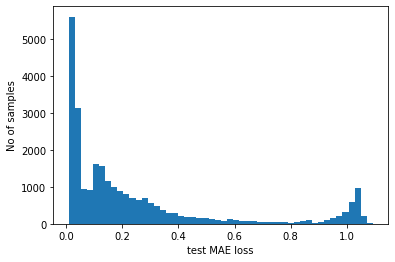

Number of anomaly samples:  3953
Indices of anomaly samples:  (array([    0,     9,    18, ..., 26496, 26505, 26514]),)


"\nfig, ax = plt.subplots(figsize=(14, 6), dpi=80)\nax.plot(history['loss'], 'b', label='Train', linewidth=2)\nax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)\nax.set_title('Model loss', fontsize=16)\nax.set_ylabel('Loss (mae)')\nax.set_xlabel('Epoch')\nax.legend(loc='upper right')\nplt.show()"

In [35]:
import tensorflow as tf
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.models import model_from_json
import numpy as np
import os
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from numpy import save
from math import*
from sklearn.metrics import classification_report
from keras.models import Model
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras import layers


action = int(input("Run training (yes-1 \ no-0)?"))

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
  filepath = prefix + group + '/Inertial Signals/'
  # load all 9 files as a single array
  filenames = list()
  # total acceleration
  filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
  # body acceleration
  filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
  # body gyroscope
  filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
  # load input data
  X = load_group(filenames, filepath)
  # load class output
  y = load_file(prefix + group + '/y_'+group+'.txt')
  return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
  # load all train
  trainX, trainy = load_dataset_group('train', prefix + 'drive/MyDrive/HARDataset/')
  print("Shape trainX and trainy:", trainX.shape, trainy.shape)
  # load all test
  testX, testy = load_dataset_group('test', prefix + 'drive/MyDrive/HARDataset/')
  subjects = read_csv('drive/MyDrive/HARDataset/train/subject_train.txt', header=None, delim_whitespace=True)
  # zero-offset class values
  trainy = trainy - 1
  testy = testy - 1
  # one hot encode y
  trainy = to_categorical(trainy)
  testy = to_categorical(testy)
  print("Shape train and test:",trainX.shape, trainy.shape, testX.shape, testy.shape)
  #print(trainX.shape[1], trainX.shape[2], trainy.shape[1]) 
  return trainX, trainy, testX, testy

def autoencoder_model(X):
  model = Sequential(
    [
        layers.Input(shape=(trainX.shape[1], trainX.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
  return model

def run_autoencoder():
  trainX, trainy, testX, testy = load_dataset()
  model = autoencoder_model(trainX)
  model.compile(optimizer='adam', loss='mae')
  #model.summary()
  nb_epochs = 1
  batch_size = 10
  history = model.fit(trainX, trainX, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history
  model_json = model.to_json()
  with open("drive/MyDrive/HARDataset/model_HV.json", "w") as json_file:
    json_file.write(model_json)
  #serialize weights to HDF5
  model.save_weights("drive/MyDrive/HARDataset/model_HV.h5")
  print("Saved model to disk")

def detect_anomalies():
  json_file = open("drive/MyDrive/HARDataset/model_HV.json", "r")
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights("drive/MyDrive/HARDataset/model_HV.h5")
  print("Loaded model from disk")
  testX_pred = model.predict(testX)
  test_mae_loss = np.mean(np.abs(testX_pred - testX), axis=1)
  test_mae_loss = test_mae_loss.reshape((-1))
  plt.hist(test_mae_loss, bins=50)
  plt.xlabel("test MAE loss")
  plt.ylabel("No of samples")
  plt.show()

  # Detect all the samples which are anomalies.
  anomalies = test_mae_loss > 0.5
  print("Number of anomaly samples: ", np.sum(anomalies))
  print("Indices of anomaly samples: ", np.where(anomalies))

if action == 1: 
  run_autoencoder()
detect_anomalies()
'''
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()'''


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
